In [200]:
import math
import random

from graphviz import Digraph


def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # gradients of Value object with respect to the final leaf node
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f'Value(data={self.data})'
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad

        out._backward = _backward

        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return self + (-other)
    
    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data*other.data, (self, other), '*')

        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += (other*self.data**(other - 1))*out.grad
        
        out._backward = _backward

        return out
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2)*out.grad
        
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1
        
        for node in reversed(topo):
            node._backward()


class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1), label = f'w{counter}') for counter in range(nin)]
        self.b = Value(random.uniform(-1, 1), label='bias')

    def __call__(self, x):
        activation = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = activation.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        params = []
        for neuron in self.neurons:
            params.extend(neuron.parameters())

        return params


class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        
        return x
    
    def parameters(self):
        params = list()
        for layer in self.layers:
            params.extend(layer.parameters())
        
        return params
        

In [ ]:
x = [2, 3, 1]
x = [Value(v, label=f'x{counter}') for counter, v in enumerate(x)]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.7072677332743285)

In [223]:
n = MLP(3, [4, 4, 1])
xs = [
    [2, 3, -1],
    [3, -1, 0.5],
    [0.5, 1, 1],
    [1, -1, -1]
] # inputs
ys = [1, -1, -1, 1] # desired targets
ypred = [n(x) for x in xs]
print(ypred)

[Value(data=0.1489742677238052), Value(data=0.357376019562363), Value(data=-0.2661962155893099), Value(data=0.3762202765547638)]


In [215]:
n.layers[0].neurons[0].w[0].data

-0.5908764924717913

In [242]:
loss = sum((yout - ytg)**2 for yout, ytg in zip(ys, ypred))

print(f'Before: {loss=}')

# change the data according to the gradients calculated during backpropogation
loss.backward()
for p in n.parameters():
    p.data += -0.01 * p.grad

ypred = [n(x) for x in xs]

loss = sum((yout - ytg)**2 for yout, ytg in zip(ys, ypred))
print(f'After 1 step: {loss=}')

Before: loss=Value(data=2.0695898337737635)
After 1 step: loss=Value(data=2.032338492548939)


In [246]:
n = MLP(3, [4, 4, 1])
xs = [
    [2, 3, -1],
    [3, -1, 0.5],
    [0.5, 1, 1],
    [1, -1, -1]
] # inputs
ys = [1, -1, -1, 1] # desired targets
ypred = [n(x) for x in xs]
print(f'Before: {ypred=}')

for k in range(10):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # zero grad
    # because all the gradients accumulate
    for p in n.parameters():
        p.grad = 0

    # backward pass
    loss.backward()

    # update
    for p in n.parameters():
        p.data += - 0.05 * p.grad
    
    print(k, loss.data)

print(f'After: {ypred=}')

Before: ypred=[Value(data=0.02996455414290431), Value(data=-0.405018577535869), Value(data=-0.20143599278098823), Value(data=-0.16703640923705326)]
0 3.294650113407216
1 1.8215058656601077
2 1.0982198132129375
3 0.5539124103739392
4 0.32395153030190366
5 0.22081702735380734
6 0.1662268569375616
7 0.13186085243030432
8 0.10858603033426735
9 0.0919254002772867
After: ypred=[Value(data=0.7870344932701073), Value(data=-0.9121197271330186), Value(data=-0.833393337846335), Value(data=0.8946891696575981)]


In [137]:
a = Value(1)
b = Value(1)
# o = a.exp()
# # draw_dot(o)
# o.backward()
# draw_dot(o)
a - b

Value(data=0)

In [ ]:
a.grad = (-2 * 3)
b.grad = (-2 * 2)
e.grad = -2
c.grad = -2
d.grad = f.data
f.grad = d.data
L.grad = 1

In [58]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = e + c
L = d * f

print(L.data)

# a = Value(2, label='a')
# b = Value(3, label='b')
# c = Value(-1, label='c')
# e = a*b; e.label = 'e'
# d = e + c; d.label = 'd'
# f = Value(-2, label='f')
# L = d * f; L.label = 'L'

print(L.data)

-9.208680000000001
-9.208680000000001


In [56]:
def lol():
    h = 0.001

    a = Value(2, label='a')
    b = Value(3, label='b')
    c = Value(-1, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2, label='a')
    a.data += h
    b = Value(3, label='b')
    c = Value(-1, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

-6.000000000000227


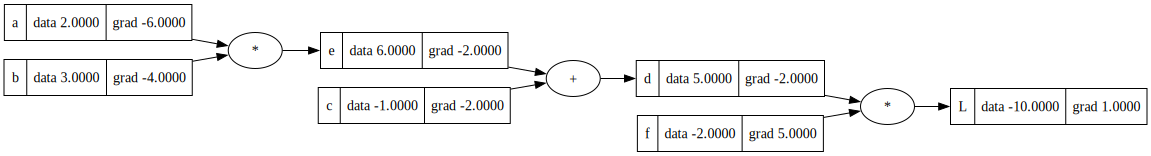

In [57]:
draw_dot(L)

In [113]:
# neuron backprop
# data
x1 = Value(2, label='x1')
x2 = Value(0, label='x2')
# weights
w1 = Value(-3, label='w1')
w2 = Value(-3, label='w2')

# bias of neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# activation function
o = n.tanh(); o.label = 'o'

In [102]:
o.grad = 1
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

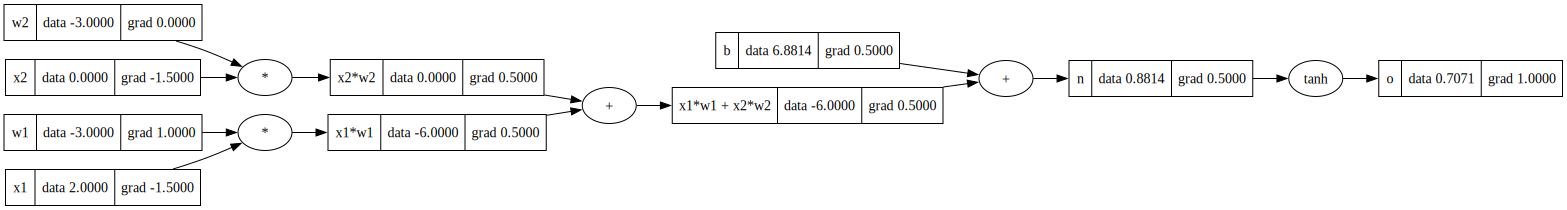

In [116]:
draw_dot(o)

In [115]:
o.backward()

In [75]:
n.grad = 0.5
o.grad = 1.0
b.grad = n.grad
x1w1x2w2.grad = n.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [66]:
1 - o.data**2

0.4999999999999999

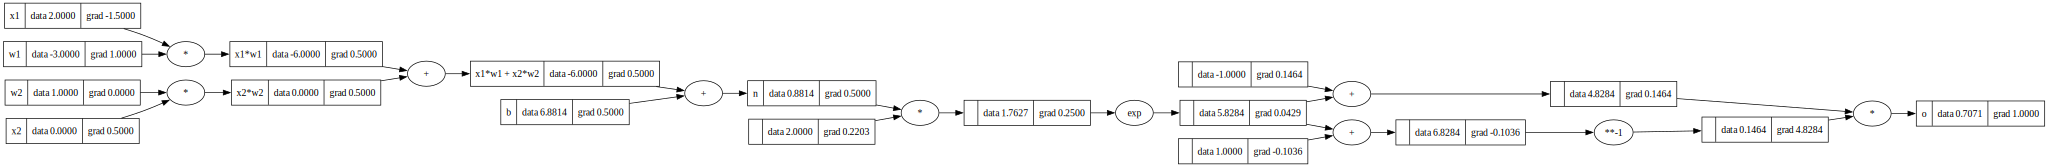

In [164]:
# neuron backprop
# data
x1 = Value(2, label='x1')
x2 = Value(0, label='x2')
# weights
w1 = Value(-3, label='w1')
w2 = Value(1, label='w2')

# bias of neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# 
e = (2*n).exp()
o = (e - 1) / (e + 1)

# activation function
# o = n.tanh(); o.label = 'o'
o.label = 'o'
o.backward()
draw_dot(o)